In [2]:
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torchvision
from torchvision.datasets import ImageFolder
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd

In [3]:
train_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomGrayscale(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees = 90),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean = (0.5, 0.5, 0.5), std = (0.5, 0.5, 0.5))
])

normalize_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean = (0.5, 0.5, 0.5), std = (0.5, 0.5, 0.5))
])

In [4]:
test_path = './catdog_data/test'
train_path = './catdog_data/train'
validation_path = './catdog_data/validation'

train_data = ImageFolder(root = train_path, transform = train_transform)
test_data = ImageFolder(root = test_path, transform = normalize_transform)
validation_data = ImageFolder(root = validation_path, transform = normalize_transform)

In [1]:
import torch

print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))
    print("CUDA version:", torch.version.cuda)
    print("Device count:", torch.cuda.device_count())
    
if torch.cuda.is_available():
    print("GPU name:", torch.cuda.get_device_name(0))
    print("Memory allocated:", round(torch.cuda.memory_allocated(0)/1024**3, 2), "GB")
    print("Memory cached:", round(torch.cuda.memory_reserved(0)/1024**3, 2), "GB")
    print("Total memory:", round(torch.cuda.get_device_properties(0).total_memory / 1024**3, 2), "GB")

num_gpus = torch.cuda.device_count()
print(f"Number of GPUs: {num_gpus}")

for i in range(num_gpus):
    print(f"GPU {i}: {torch.cuda.get_device_name(i)}")

import torch
print("CUDA available:", torch.cuda.is_available())
print("CUDA version:", torch.version.cuda)
print("Device count:", torch.cuda.device_count())
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))

CUDA available: True
GPU: NVIDIA GeForce GTX 1660
CUDA version: 12.1
Device count: 1
GPU name: NVIDIA GeForce GTX 1660
Memory allocated: 0.0 GB
Memory cached: 0.0 GB
Total memory: 6.0 GB
Number of GPUs: 1
GPU 0: NVIDIA GeForce GTX 1660
CUDA available: True
CUDA version: 12.1
Device count: 1
GPU: NVIDIA GeForce GTX 1660


In [6]:
import pickle

class CNN(nn.Module):

    def __init__(self, activation_function):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 128, kernel_size = 3, padding = 1)
        self.act1 = activation_function
        self.maxpool1 = nn.MaxPool2d(kernel_size = 2)
        self.conv2 = nn.Conv2d(in_channels = 128, out_channels = 64, kernel_size = 3, padding = 1)
        self.act2 = activation_function
        self.maxpool2 = nn.MaxPool2d(kernel_size = 2)
        self.conv3 = nn.Conv2d(in_channels = 64, out_channels = 32, kernel_size = 3, padding = 1)
        self.act3 = activation_function
        self.maxpool3 = nn.MaxPool2d(kernel_size = 2)
        self.conv4 = nn.Conv2d(in_channels = 32, out_channels = 2, kernel_size = 3, padding = 1)
        self.act4 = activation_function
        self.maxpool4 = nn.MaxPool2d(kernel_size = 2)

        self.dropout = nn.Dropout(0.2)
        self.fc1 = nn.Linear(2 * 4 * 4, 128)
        self.fc2 = nn.Linear(128, 2)
        self.act5 = activation_function
    
    def forward(self, x):
        x = self.act1(self.conv1(x))
        x = self.maxpool1(x)
        x = self.act2(self.conv2(x))
        x = self.maxpool2(x)
        x = self.act3(self.conv3(x))
        x = self.maxpool3(x)
        x = self.act4(self.conv4(x))
        x = self.maxpool4(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.act5(self.fc1(x))
        x = self.fc2(x)
        return x

def train(network, data_loader, criterion, optimizer, device):
    network.train()
    running_loss = 0.0
    for data, target in data_loader:
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = network(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * data.size(0)
    
    return running_loss / len(data_loader.dataset)

def validation(network, data_loader, criterion, device):
    network.eval()
    correct = 0
    total = 0
    val_loss = 0.0

    with torch.no_grad():
        for data, target in data_loader:
            data, target = data.to(device), target.to(device)

            output = network(data)
            loss = criterion(output, target)
            val_loss += loss.item() * data.size(0)
            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
    
    return val_loss / len(data_loader.dataset), 100 * correct / total

results = []

batch_sizes = [64, 128, 256]
learning_rates = [0.1, 0.01, 0.001]

# activation_functions = {
#     'ReLU': nn.ReLU(),
#     'Sigmoid': nn.Sigmoid(),
#     'Tanh': nn.Tanh(),
#     'LeakyReLU': nn.LeakyReLU(),
#     'LogSigmoid': nn.LogSigmoid(),
#     'ELU': nn.ELU(),
#     'SiLU': nn.SiLU(),
#     'Softplus': nn.Softplus()
# }

activation_functions = {
    'Softplus': nn.Softplus()
}

optimizers = {
    'Stochastic Gradient Descent': optim.SGD,
    'Adam': optim.Adam
}

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_epochs = 15

for act_name, activation_function in activation_functions.items():
    print(f"Testing parameters for activation function {act_name}")

    activation_results = []

    for batch_size in batch_sizes:
        print(f"\n=== Batch size: {batch_size} ===")

        train_dataloader = DataLoader(
            dataset = train_data,
            batch_size = batch_size,
            shuffle = True,
            num_workers = 2
        )

        validation_dataloader = DataLoader(
            dataset = validation_data,
            batch_size = batch_size,
            shuffle = False,
            num_workers = 2
        )

        test_dataloader = DataLoader(
            dataset = test_data,
            batch_size = batch_size,
            shuffle = False,
            num_workers = 2
        )

        for learning_rate in learning_rates:
            print(f"\n --- Learning rate: {learning_rate} ---")

            for opt_name, optimizer in optimizers.items():
                print(f"\nOptimizing {act_name} with {opt_name}...")

                model = CNN(activation_function).to(device)
                criterion = nn.CrossEntropyLoss()
                optimizer = optimizer(model.parameters(), lr = learning_rate)

                train_loss_history = []
                val_loss_history = []
                val_accuracy_history = []

                for epoch in range(num_epochs):
                    train_loss = train(model, train_dataloader, criterion, optimizer, device)
                    val_loss, val_accuracy = validation(model, validation_dataloader, criterion, device)

                    train_loss_history.append(train_loss)
                    val_loss_history.append(val_loss)
                    val_accuracy_history.append(val_accuracy)

                    print(f"Epoch [{epoch + 1}/{num_epochs}], Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f} %")

                results.append({
                    "batch_size": batch_size,
                    "learning_rate": learning_rate,
                    "activation_function": act_name,
                    "optimizer": opt_name,
                    "train_loss_history": train_loss_history,
                    "val_loss_history": val_loss_history,
                    "val_accuracy_history": val_accuracy_history
                })

                activation_results.append({
                    "batch_size": batch_size,
                    "learning_rate": learning_rate,
                    "optimizer": opt_name,
                    "train_loss_history": train_loss_history,
                    "val_loss_history": val_loss_history,
                    "val_accuracy_history": val_accuracy_history
                })

    with open(f"cnn_experiments_{act_name}.pkl", "wb") as f:
        pickle.dump(activation_results, f)
    
    print(f"\nResults saved for {act_name}")

# with open(f"cnn_experiments.pkl", "wb") as f:
#     pickle.dump(results, f)

print("\nAll results saved")

Testing parameters for activation function Softplus

=== Batch size: 64 ===

 --- Learning rate: 0.1 ---

Optimizing Softplus with Stochastic Gradient Descent...
Epoch [1/15], Validation Loss: 1.9827, Validation Accuracy: 50.00 %
Epoch [2/15], Validation Loss: 0.8414, Validation Accuracy: 50.00 %
Epoch [3/15], Validation Loss: 0.7081, Validation Accuracy: 50.00 %
Epoch [4/15], Validation Loss: 0.6976, Validation Accuracy: 50.00 %
Epoch [5/15], Validation Loss: 0.6941, Validation Accuracy: 50.00 %
Epoch [6/15], Validation Loss: 0.8530, Validation Accuracy: 50.00 %
Epoch [7/15], Validation Loss: 0.7458, Validation Accuracy: 50.00 %
Epoch [8/15], Validation Loss: 0.6991, Validation Accuracy: 50.00 %
Epoch [9/15], Validation Loss: 0.6966, Validation Accuracy: 50.00 %
Epoch [10/15], Validation Loss: 0.6950, Validation Accuracy: 50.00 %
Epoch [11/15], Validation Loss: 0.7008, Validation Accuracy: 50.00 %
Epoch [12/15], Validation Loss: 0.6942, Validation Accuracy: 50.00 %
Epoch [13/15], Vali

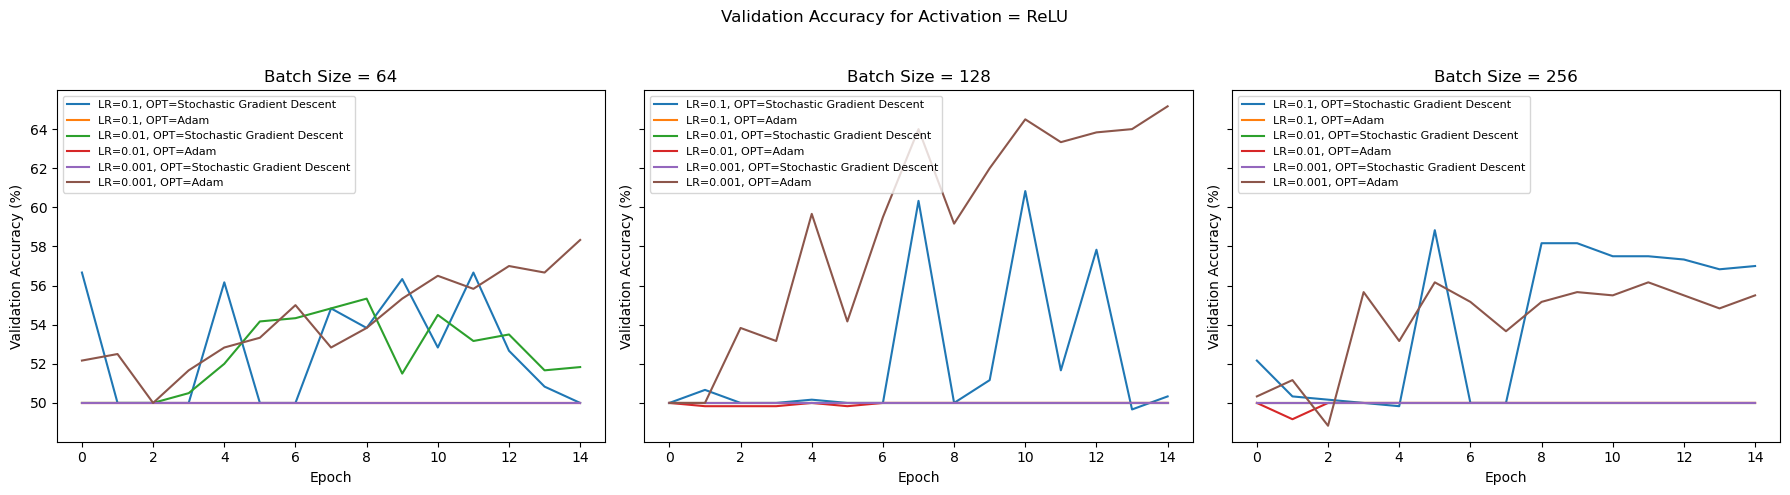

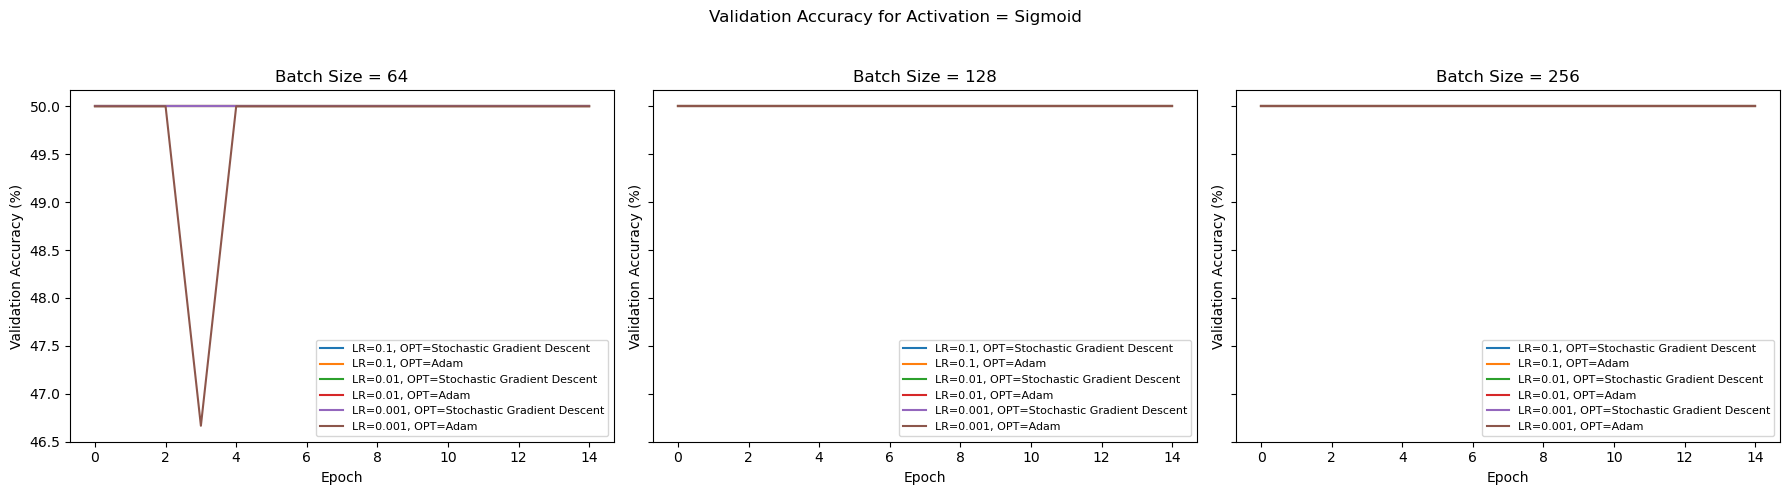

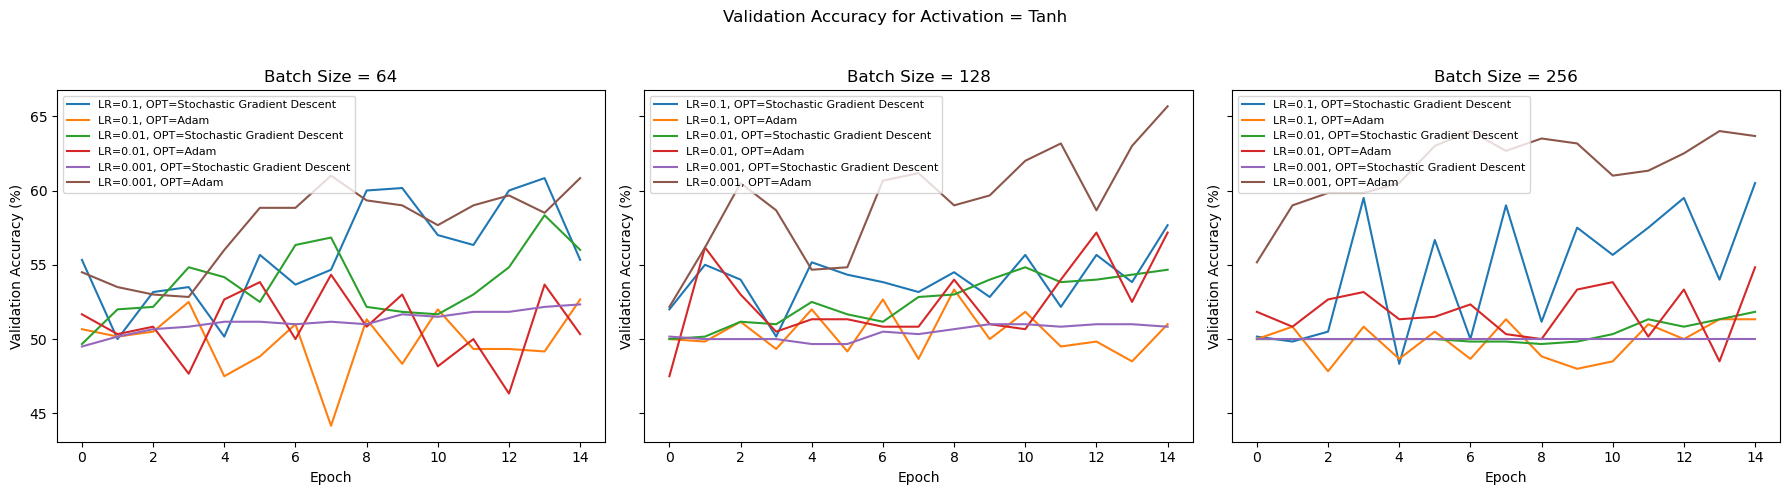

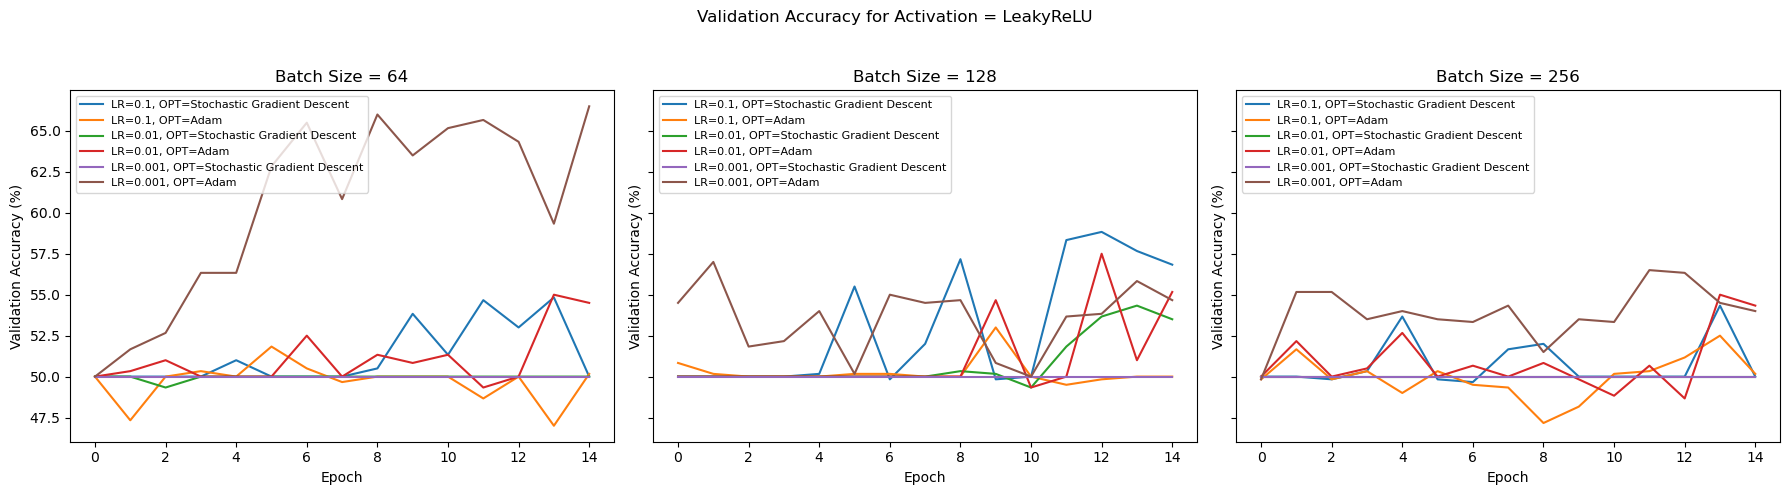

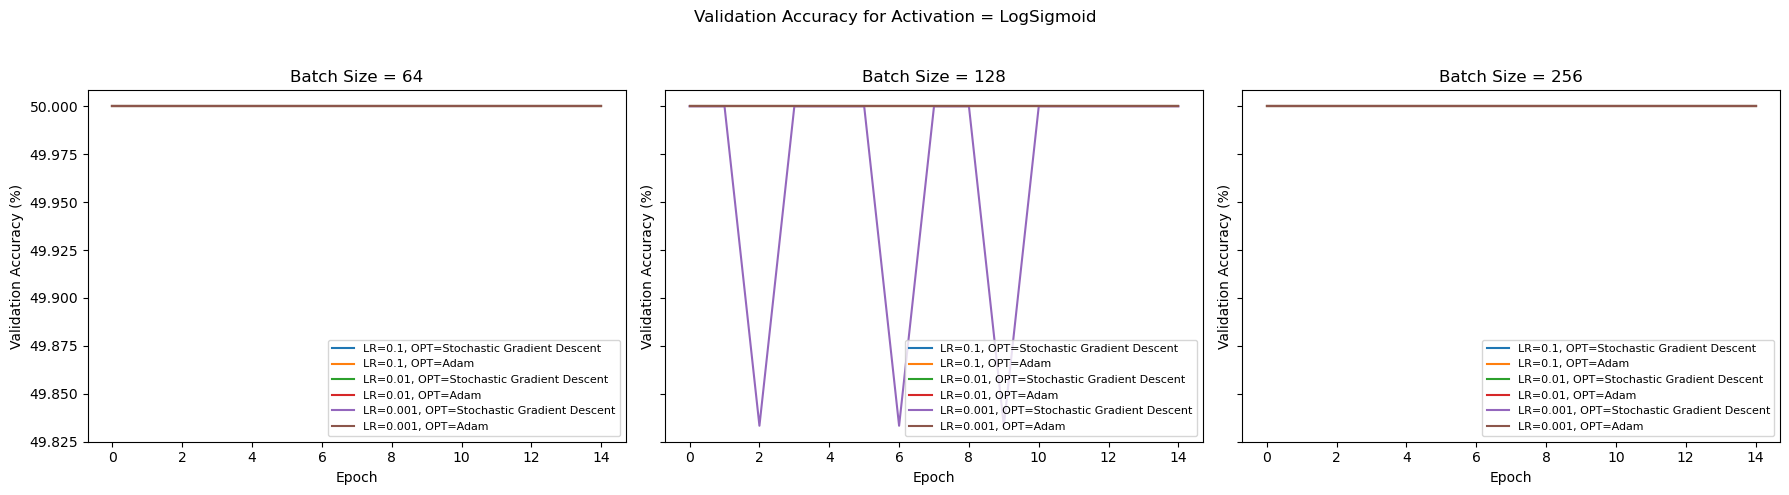

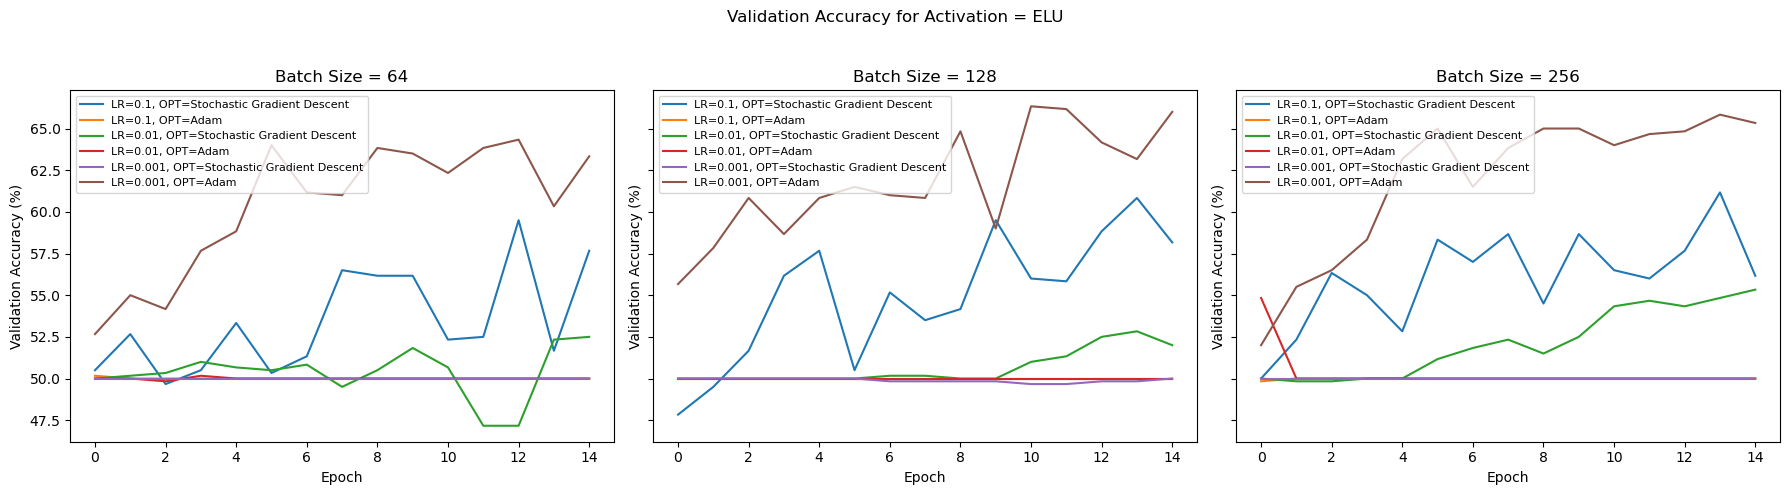

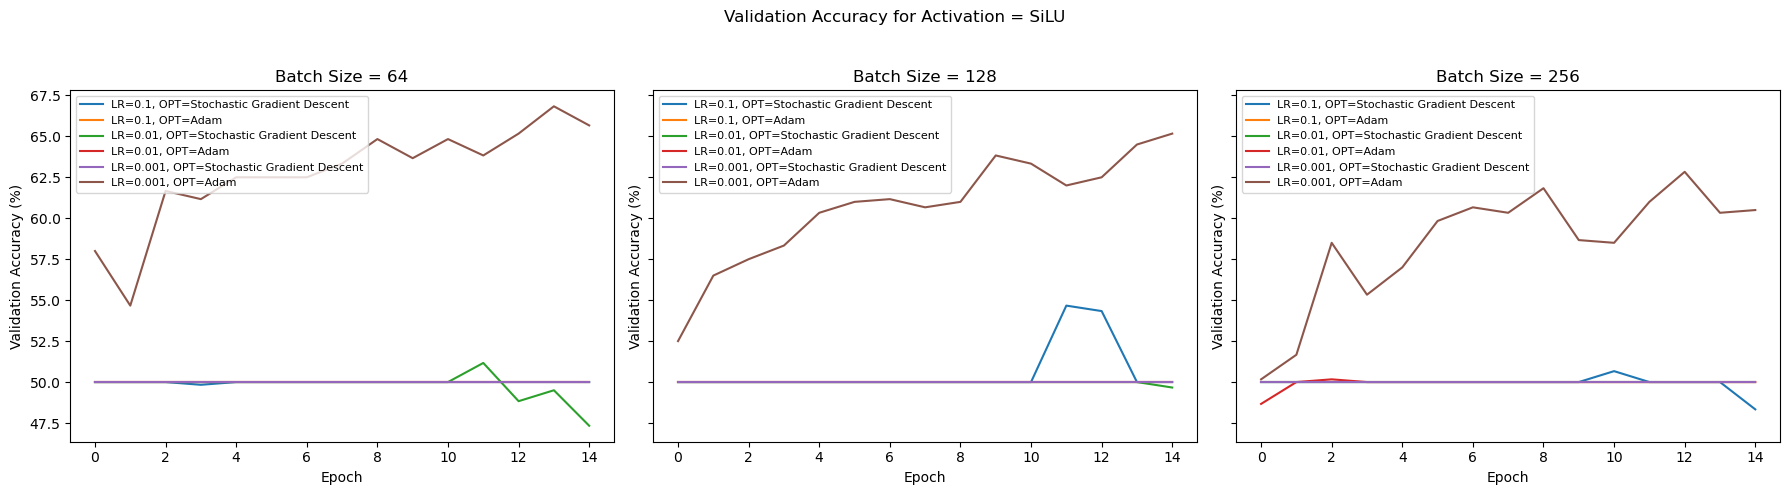

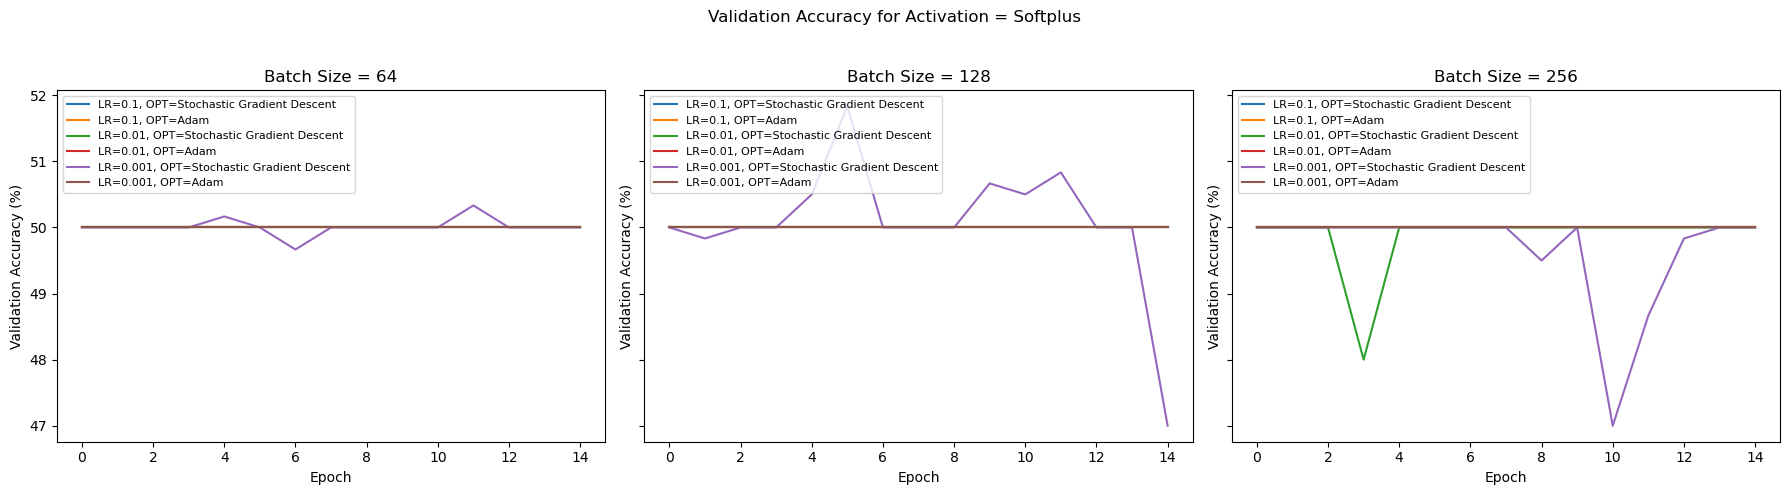

In [19]:
import matplotlib.pyplot as plt
import pickle
import pandas as pd

with open("cnn_experiments.pkl", "rb") as f:
    results = pickle.load(f)

df = pd.DataFrame(results)

subset_relu = df[(df["activation_function"] == "ReLU")]
subset_sigmoid = df[(df["activation_function"] == "Sigmoid")]
subset_tanh = df[(df["activation_function"] == "Tanh")]
subset_leakyrelu = df[(df["activation_function"] == "LeakyReLU")]
subset_logsigmoid = df[(df["activation_function"] == "LogSigmoid")]
subset_elu = df[(df["activation_function"] == "ELU")]
subset_silu = df[(df["activation_function"] == "SiLU")]
subset_softplus = df[(df["activation_function"] == "Softplus")]

# ReLU figure
batch_sizes = subset_relu['batch_size'].unique()

fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

for ax, batch_size in zip(axes, batch_sizes):
    subset_bs = subset_relu[subset_relu['batch_size'] == batch_size]

    for _, row in subset_bs.iterrows():
        label = f"LR={row['learning_rate']}, OPT={row['optimizer']}"
        ax.plot(row['val_accuracy_history'], label=label)

    ax.set_title(f"Batch Size = {batch_size}")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Validation Accuracy (%)")
    ax.legend(fontsize=8, loc='upper left')

fig.suptitle(f"Validation Accuracy for Activation = {subset_relu['activation_function'].iloc[0]}")
fig.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

#Sigmoid figure
batch_sizes = subset_sigmoid['batch_size'].unique()

fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

for ax, batch_size in zip(axes, batch_sizes):
    subset_bs = subset_sigmoid[subset_sigmoid['batch_size'] == batch_size]

    for _, row in subset_bs.iterrows():
        label = f"LR={row['learning_rate']}, OPT={row['optimizer']}"
        ax.plot(row['val_accuracy_history'], label=label)

    ax.set_title(f"Batch Size = {batch_size}")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Validation Accuracy (%)")
    ax.legend(fontsize=8, loc='lower right')

fig.suptitle(f"Validation Accuracy for Activation = {subset_sigmoid['activation_function'].iloc[0]}")
fig.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# Tanh figure
batch_sizes = subset_tanh['batch_size'].unique()

fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

for ax, batch_size in zip(axes, batch_sizes):
    subset_bs = subset_tanh[subset_tanh['batch_size'] == batch_size]

    for _, row in subset_bs.iterrows():
        label = f"LR={row['learning_rate']}, OPT={row['optimizer']}"
        ax.plot(row['val_accuracy_history'], label=label)

    ax.set_title(f"Batch Size = {batch_size}")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Validation Accuracy (%)")
    ax.legend(fontsize=8, loc='upper left')

fig.suptitle(f"Validation Accuracy for Activation = {subset_tanh['activation_function'].iloc[0]}")
fig.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# Leaky ReLU figure
batch_sizes = subset_leakyrelu['batch_size'].unique()

fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

for ax, batch_size in zip(axes, batch_sizes):
    subset_bs = subset_leakyrelu[subset_leakyrelu['batch_size'] == batch_size]

    for _, row in subset_bs.iterrows():
        label = f"LR={row['learning_rate']}, OPT={row['optimizer']}"
        ax.plot(row['val_accuracy_history'], label=label)

    ax.set_title(f"Batch Size = {batch_size}")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Validation Accuracy (%)")
    ax.legend(fontsize=8, loc='upper left')

fig.suptitle(f"Validation Accuracy for Activation = {subset_leakyrelu['activation_function'].iloc[0]}")
fig.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# LogSigmoid figure
batch_sizes = subset_logsigmoid['batch_size'].unique()

fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

for ax, batch_size in zip(axes, batch_sizes):
    subset_bs = subset_logsigmoid[subset_logsigmoid['batch_size'] == batch_size]

    for _, row in subset_bs.iterrows():
        label = f"LR={row['learning_rate']}, OPT={row['optimizer']}"
        ax.plot(row['val_accuracy_history'], label=label)

    ax.set_title(f"Batch Size = {batch_size}")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Validation Accuracy (%)")
    ax.legend(fontsize=8, loc='lower right')

fig.suptitle(f"Validation Accuracy for Activation = {subset_logsigmoid['activation_function'].iloc[0]}")
fig.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# ELU figure
batch_sizes = subset_elu['batch_size'].unique()

fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

for ax, batch_size in zip(axes, batch_sizes):
    subset_bs = subset_elu[subset_elu['batch_size'] == batch_size]

    for _, row in subset_bs.iterrows():
        label = f"LR={row['learning_rate']}, OPT={row['optimizer']}"
        ax.plot(row['val_accuracy_history'], label=label)

    ax.set_title(f"Batch Size = {batch_size}")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Validation Accuracy (%)")
    ax.legend(fontsize=8, loc='upper left')

fig.suptitle(f"Validation Accuracy for Activation = {subset_elu['activation_function'].iloc[0]}")
fig.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# SiLU figure
batch_sizes = subset_silu['batch_size'].unique()

fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

for ax, batch_size in zip(axes, batch_sizes):
    subset_bs = subset_silu[subset_silu['batch_size'] == batch_size]

    for _, row in subset_bs.iterrows():
        label = f"LR={row['learning_rate']}, OPT={row['optimizer']}"
        ax.plot(row['val_accuracy_history'], label=label)

    ax.set_title(f"Batch Size = {batch_size}")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Validation Accuracy (%)")
    ax.legend(fontsize=8, loc='upper left')

fig.suptitle(f"Validation Accuracy for Activation = {subset_silu['activation_function'].iloc[0]}")
fig.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# Softplus figure
batch_sizes = subset_softplus['batch_size'].unique()

fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

for ax, batch_size in zip(axes, batch_sizes):
    subset_bs = subset_softplus[subset_softplus['batch_size'] == batch_size]

    for _, row in subset_bs.iterrows():
        label = f"LR={row['learning_rate']}, OPT={row['optimizer']}"
        ax.plot(row['val_accuracy_history'], label=label)

    ax.set_title(f"Batch Size = {batch_size}")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Validation Accuracy (%)")
    ax.legend(fontsize=8, loc='upper left')

fig.suptitle(f"Validation Accuracy for Activation = {subset_softplus['activation_function'].iloc[0]}")
fig.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()